In [1]:
# vgg16 model used for transfer learning on the dogs and cats dataset
import sys
from time import time
from matplotlib import pyplot
from keras.utils import to_categorical
from keras.applications.mobilenet import MobileNet
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras.optimizers import Adadelta
from keras.optimizers import Adagrad
from keras.optimizers import Adam
from keras.optimizers import Adamax
from keras.optimizers import Nadam
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model

# baseline model for the dogs vs cats dataset
import sys
from matplotlib import pyplot
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Activation
from keras.layers import Add
from keras.layers import Dropout
from keras.layers import GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import TensorBoard
from keras import backend as K

from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import numpy as np
from math import exp
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import classification_report

from pathlib import Path
from PIL import Image
import imagesize

Using TensorFlow backend.


In [2]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
    plt.plot(history.history['loss'],
                color='blue', label='loss train')
    plt.plot(history.history['val_loss'],
                color='orange', label='loss test')
    plt.plot(history.history['accuracy'],
                color='green', label='accuracy train')
    plt.plot(history.history['val_accuracy'],
                color='red', label='accuracy test')
    plt.ylim(bottom = -0.1, top = 1.1)
    plt.legend()
    plt.show()


def pretty_print_conf_matrix(y_true, y_pred, 
                             classes,
                             normalize=False,
                             title='Confusion matrix',
                             cmap=plt.cm.Blues):
    """
    Mostly stolen from: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

    Normalization changed, classification_report stats added below plot
    """

    cm = confusion_matrix(y_true, y_pred)

    # Configure Confusion Matrix Plot Aesthetics (no text yet) 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)

    # Calculate normalized values (so all cells sum to 1) if desired
    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(),2) #(axis=1)[:, np.newaxis]

    # Place Numbers as Text on Confusion Matrix Plot
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=12)


    # Add Precision, Recall, F-1 Score as Captions Below Plot
    rpt = classification_report(y_true, y_pred)
    rpt = rpt.replace('avg / total', '      avg')
    rpt = rpt.replace('support', 'N Obs')

    plt.annotate(rpt, 
                 xy = (0,0), 
                 xytext = (-50, -140), 
                 xycoords='axes fraction', textcoords='offset points',
                 fontsize=12, ha='right')    

    # Plot
    plt.tight_layout()


def print_metrics(model, datagen, test_path):
    
    test_it = datagen.flow_from_directory(test_path,
                                          class_mode='binary',
                                          batch_size=64,
                                          target_size=(240, 320))
    
    test_generator = datagen.flow_from_directory(test_path,
                                          class_mode='binary',
                                          batch_size=1,
                                          target_size=(240, 320))    
    # predict probabilities for test set
    filenames = test_generator.filenames
    nb_samples = len(filenames)
    true_values = []
    predictions = []
    for i in range(nb_samples):
        x_batch, y_batch = test_generator.next()
        name = model.predict(x_batch)
        name =  (name>0.5).astype(int)[0][0]
        true_name = y_batch[0].astype(np.int)
        label_map = (test_generator.class_indices)
        label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
        prediction = label_map[name]
        true_value = label_map[true_name]
        true_values.append(true_value)
        predictions.append(prediction) 
    plt.figure()
    pretty_print_conf_matrix(true_values, predictions, 
                             classes= ['Female', 'Male'])



def exp_decay(epoch):
    initial_lrate = 0.01
    k = 0.05
    lrate = initial_lrate * exp(-k*epoch)
    return lrate

def read_pil_image(img_path, height, width):
        with open(img_path, 'rb') as f:
            return np.array(Image.open(f).convert('RGB').resize((width, height)))

def load_all_images(dataset_path, height, width, img_ext='png'):
    return np.array([read_pil_image(str(p), height, width) for p in 
                                    Path(dataset_path).rglob("*."+img_ext)]) 

def normalise_features(array):
    min_value = -1
    max_value = 1
    return np.interp(array, (np.amin(array), np.amax(array)),
                     (min_value, max_value))


### Plot Male and Female photos

In [6]:
import random
random.seed(1)

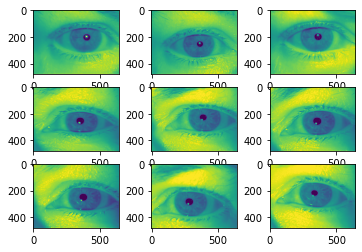

In [7]:
# plot iris data
from matplotlib import pyplot
from matplotlib.image import imread
# define location of dataset
import matplotlib.pyplot as plt

from os import listdir
from os.path import isfile, join
folder = '../data/raw/iris_data/LG2200/gender/'
onlyfiles = [f for f in listdir(folder+'Female')
             if isfile(join(folder+'Female', f))]

# plot first few images
for i in range(9):
    # define subplot
    pyplot.subplot(330 + 1 + i)
    # define filename
    filename = folder+'Female/'+onlyfiles[i]
    # load image pixels
    image = imread(filename, 'tiff')
    # plot raw pixel data
    pyplot.imshow(image)
# show the figure
pyplot.show()

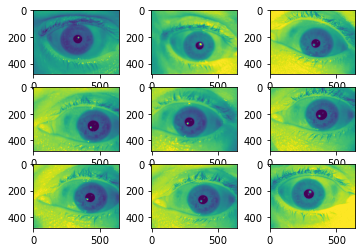

<Figure size 432x288 with 0 Axes>

In [8]:
# plot iris data
from matplotlib import pyplot
from matplotlib.image import imread
# define location of dataset
folder = '../data/raw/iris_data/LG2200/gender/'
onlyfiles = [f for f in listdir(folder+'Male')
             if isfile(join(folder+'Male', f))]

# plot first few images
for i in range(9):
    # define subplot
    pyplot.subplot(330 + 1 + i)
    # define filename
    filename = folder+'Male/'+onlyfiles[i]
    # load image pixels
    image = imread(filename)
    # plot raw pixel data
    pyplot.imshow(image)

# show the figure
fig1 = pyplot.gcf()
pyplot.show()
pyplot.draw()
pyplot.savefig('../data/iris_results.png')

### Checking data loading

In [10]:
from PIL import Image as pilimage, Image
file_path='../data/processed/iris_data/LG2200/gender/train/Male/02463d1896.tiff'
im = Image.open(file_path)
im.show()

In [11]:
from PIL import Image
import numpy 

im = Image.open(file_path) 
imarray = numpy.array(im) 
imarray.shape 
im.show()

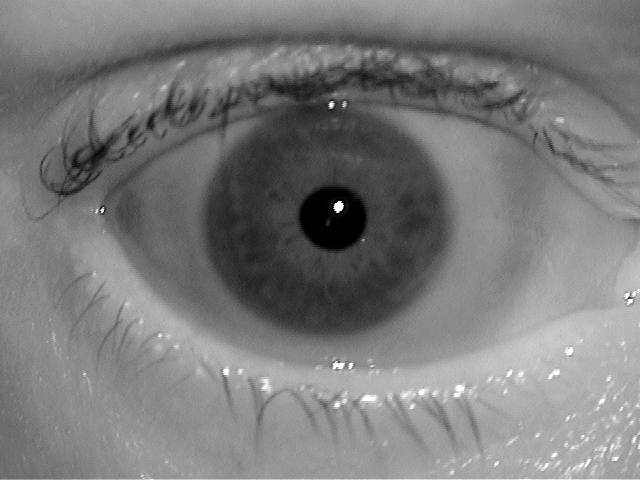

In [12]:
im

In [13]:
imarray

array([[140, 141, 144, ..., 107, 114, 114],
       [141, 140, 140, ..., 114, 117, 110],
       [140, 140, 147, ..., 107, 110, 113],
       ...,
       [ 96, 107, 113, ..., 158, 161, 161],
       [104, 107, 111, ..., 155, 152, 155],
       [147, 152, 147, ..., 215, 204, 194]], dtype=uint8)

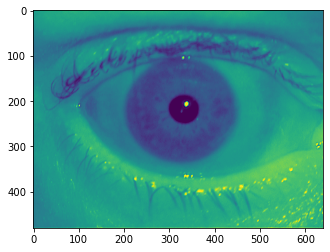

In [14]:
from matplotlib import pyplot
from matplotlib.image import imread
image = imread(file_path)
# plot raw pixel data
pyplot.imshow(image)

In [15]:
image

array([[140, 141, 144, ..., 107, 114, 114],
       [141, 140, 140, ..., 114, 117, 110],
       [140, 140, 147, ..., 107, 110, 113],
       ...,
       [ 96, 107, 113, ..., 158, 161, 161],
       [104, 107, 111, ..., 155, 152, 155],
       [147, 152, 147, ..., 215, 204, 194]], dtype=uint8)

In [16]:
imarray.shape

(480, 640)

### Data Augmentation
* Feature Standardization
* ZCA Whitening
* Random Rotations
* Random Shifts
* Random Flips

#### Feature Standardization

In [26]:
# run the test harness for evaluating a model
#def run_test_harness():
batch_size = 1


640 480
Found 3561 images belonging to 2 classes.
Found 1032 images belonging to 2 classes.


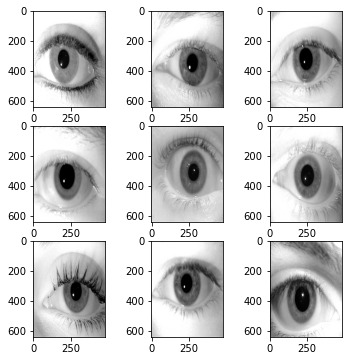

Found 3561 images belonging to 2 classes.
Found 1032 images belonging to 2 classes.


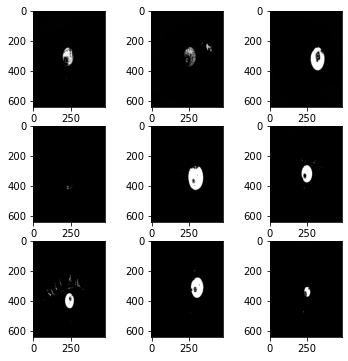

In [65]:
# example of horizontal shift image augmentation
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
import matplotlib.pyplot as plt

# entry point, run the test harness
file = '../data/processed/iris_data/LG2200/gender/train/Male/02463d1896.tiff'
width, height = imagesize.get(file)
print(width, height)


# entry point, run the test harness
dataset_home = '../data/processed/iris_data/LG2200/gender/'

train_path = dataset_home + 'train/'
test_path = dataset_home + 'test/'


train_datagen = ImageDataGenerator()


# prepare iterators
train_it = train_datagen.flow_from_directory(train_path,
    class_mode='binary', batch_size=batch_size, target_size=(640, 480))
test_it = train_datagen.flow_from_directory(test_path,
    class_mode='binary', batch_size=batch_size, target_size=(640, 480)) 



train_it.reset

fig = plt.figure(figsize=(6, 6))

# plot first few images
for i in range(9):
    # define subplot
    ax = fig.add_subplot(3,3, i+1)
    # generate batch of images
    x_batch, y_batch = train_it.next()
    # convert to unsigned integers for viewing
    image = x_batch[0].astype('uint8')
    # plot raw pixel data
    plt.imshow(image)
# show the figure
plt.show()



# prueba = load_all_images(train_path+'Male', height, width, 'tiff')

train_datagen = ImageDataGenerator(preprocessing_function=normalise_features)
train_datagen.fit(load_all_images(train_path+'Male', height, width, 'tiff'))
train_datagen.fit(load_all_images(train_path+'Female', height, width, 'tiff'))


# prepare iterators
train_it = train_datagen.flow_from_directory(train_path,
    class_mode='binary', batch_size=batch_size, target_size=(640, 480))
test_it = train_datagen.flow_from_directory(test_path,
    class_mode='binary', batch_size=batch_size, target_size=(640, 480)) 



train_it.reset
fig = plt.figure(figsize=(6, 6))
    
# plot first few images
for i in range(9):
    # define subplot
    ax = fig.add_subplot(3,3, i+1)
    # generate batch of images
    x_batch, y_batch = train_it.next()
    # convert to unsigned integers for viewing
    image = x_batch[0].astype('uint8')
    # plot raw pixel data
    plt.imshow(image)
# show the figure
plt.show()



#### Random Rotations

640 480
Found 3561 images belonging to 2 classes.
Found 1032 images belonging to 2 classes.


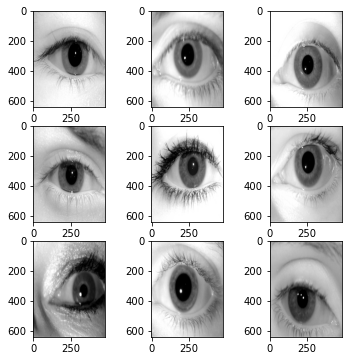

Found 3561 images belonging to 2 classes.
Found 1032 images belonging to 2 classes.


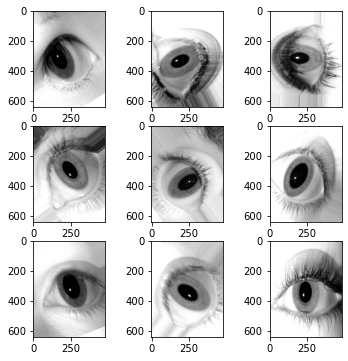

In [7]:
# example of horizontal shift image augmentation
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
import matplotlib.pyplot as plt

batch_size = 1

# entry point, run the test harness
file = '../data/processed/iris_data/LG2200/gender/train/Male/02463d1896.tiff'
width, height = imagesize.get(file)
print(width, height)


# entry point, run the test harness
dataset_home = '../data/processed/iris_data/LG2200/gender/'

train_path = dataset_home + 'train/'
test_path = dataset_home + 'test/'


train_datagen = ImageDataGenerator()


# prepare iterators
train_it = train_datagen.flow_from_directory(train_path,
    class_mode='binary', batch_size=batch_size, target_size=(640, 480))
test_it = train_datagen.flow_from_directory(test_path,
    class_mode='binary', batch_size=batch_size, target_size=(640, 480)) 



train_it.reset

fig = plt.figure(figsize=(6, 6))

# plot first few images
for i in range(9):
    # define subplot
    ax = fig.add_subplot(3,3, i+1)
    # generate batch of images
    x_batch, y_batch = train_it.next()
    # convert to unsigned integers for viewing
    image = x_batch[0].astype('uint8')
    # plot raw pixel data
    plt.imshow(image)
# show the figure
plt.show()



# prueba = load_all_images(train_path+'Male', height, width, 'tiff')
# train_datagen = ImageDataGenerator(preprocessing_function=normalise_features, rotation_range=90)
train_datagen = ImageDataGenerator(rotation_range=90)
train_datagen.fit(load_all_images(train_path+'Male', height, width, 'tiff'))
train_datagen.fit(load_all_images(train_path+'Female', height, width, 'tiff'))


# prepare iterators
train_it = train_datagen.flow_from_directory(train_path,
    class_mode='binary', batch_size=batch_size, target_size=(640, 480))
test_it = train_datagen.flow_from_directory(test_path,
    class_mode='binary', batch_size=batch_size, target_size=(640, 480)) 



train_it.reset
fig = plt.figure(figsize=(6, 6))
    
# plot first few images
for i in range(9):
    # define subplot
    ax = fig.add_subplot(3,3, i+1)
    # generate batch of images
    x_batch, y_batch = train_it.next()
    # convert to unsigned integers for viewing
    image = x_batch[0].astype('uint8')
    # plot raw pixel data
    plt.imshow(image)
# show the figure
plt.show()



#### Random Shifts

640 480
Found 3561 images belonging to 2 classes.
Found 1032 images belonging to 2 classes.


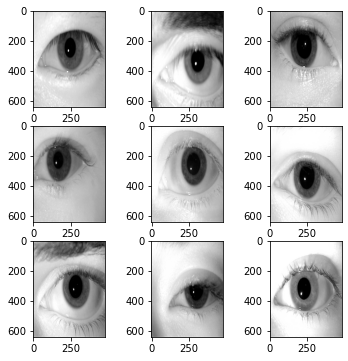

Found 3561 images belonging to 2 classes.
Found 1032 images belonging to 2 classes.


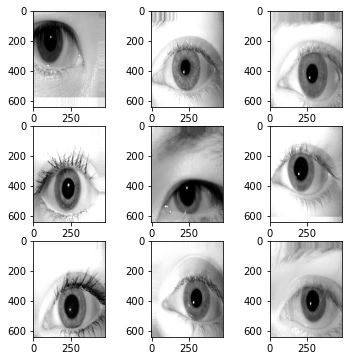

In [9]:
# example of horizontal shift image augmentation
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
import matplotlib.pyplot as plt

batch_size = 1

# entry point, run the test harness
file = '../data/processed/iris_data/LG2200/gender/train/Male/02463d1896.tiff'
width, height = imagesize.get(file)
print(width, height)


# entry point, run the test harness
dataset_home = '../data/processed/iris_data/LG2200/gender/'

train_path = dataset_home + 'train/'
test_path = dataset_home + 'test/'


train_datagen = ImageDataGenerator()


# prepare iterators
train_it = train_datagen.flow_from_directory(train_path,
    class_mode='binary', batch_size=batch_size, target_size=(640, 480))
test_it = train_datagen.flow_from_directory(test_path,
    class_mode='binary', batch_size=batch_size, target_size=(640, 480)) 



train_it.reset

fig = plt.figure(figsize=(6, 6))

# plot first few images
for i in range(9):
    # define subplot
    ax = fig.add_subplot(3,3, i+1)
    # generate batch of images
    x_batch, y_batch = train_it.next()
    # convert to unsigned integers for viewing
    image = x_batch[0].astype('uint8')
    # plot raw pixel data
    plt.imshow(image)
# show the figure
plt.show()



# prueba = load_all_images(train_path+'Male', height, width, 'tiff')
shift = 0.1
# train_datagen = ImageDataGenerator(preprocessing_function=normalise_features,width_shift_range=shift, height_shift_range=shift)
train_datagen = ImageDataGenerator(width_shift_range=shift, height_shift_range=shift)
train_datagen.fit(load_all_images(train_path+'Male', height, width, 'tiff'))
train_datagen.fit(load_all_images(train_path+'Female', height, width, 'tiff'))


# prepare iterators
train_it = train_datagen.flow_from_directory(train_path,
    class_mode='binary', batch_size=batch_size, target_size=(640, 480))
test_it = train_datagen.flow_from_directory(test_path,
    class_mode='binary', batch_size=batch_size, target_size=(640, 480)) 



train_it.reset
fig = plt.figure(figsize=(6, 6))
    
# plot first few images
for i in range(9):
    # define subplot
    ax = fig.add_subplot(3,3, i+1)
    # generate batch of images
    x_batch, y_batch = train_it.next()
    # convert to unsigned integers for viewing
    image = x_batch[0].astype('uint8')
    # plot raw pixel data
    plt.imshow(image)
# show the figure
plt.show()



##### Random Zoom Augmentation

640 480
Found 3561 images belonging to 2 classes.
Found 1032 images belonging to 2 classes.


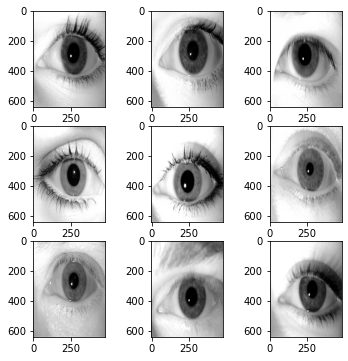

Found 3561 images belonging to 2 classes.
Found 1032 images belonging to 2 classes.


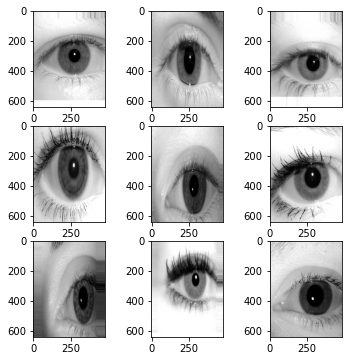

In [6]:
# example of horizontal shift image augmentation
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
import matplotlib.pyplot as plt

batch_size = 1

# entry point, run the test harness
file = '../data/processed/iris_data/LG2200/gender/train/Male/02463d1896.tiff'
width, height = imagesize.get(file)
print(width, height)


# entry point, run the test harness
dataset_home = '../data/processed/iris_data/LG2200/gender/'

train_path = dataset_home + 'train/'
test_path = dataset_home + 'test/'


train_datagen = ImageDataGenerator()


# prepare iterators
train_it = train_datagen.flow_from_directory(train_path,
    class_mode='binary', batch_size=batch_size, target_size=(640, 480))
test_it = train_datagen.flow_from_directory(test_path,
    class_mode='binary', batch_size=batch_size, target_size=(640, 480)) 



train_it.reset

fig = plt.figure(figsize=(6, 6))

# plot first few images
for i in range(9):
    # define subplot
    ax = fig.add_subplot(3,3, i+1)
    # generate batch of images
    x_batch, y_batch = train_it.next()
    # convert to unsigned integers for viewing
    image = x_batch[0].astype('uint8')
    # plot raw pixel data
    plt.imshow(image)
# show the figure
plt.show()



# prueba = load_all_images(train_path+'Male', height, width, 'tiff')
shift = 0.1
# train_datagen = ImageDataGenerator(preprocessing_function=normalise_features,zoom_range=0.3)
train_datagen = ImageDataGenerator(zoom_range=0.3)
# train_datagen.fit(load_all_images(train_path+'Male', height, width, 'tiff'))
# train_datagen.fit(load_all_images(train_path+'Female', height, width, 'tiff'))


# prepare iterators
train_it = train_datagen.flow_from_directory(train_path,
    class_mode='binary', batch_size=batch_size, target_size=(640, 480))
test_it = train_datagen.flow_from_directory(test_path,
    class_mode='binary', batch_size=batch_size, target_size=(640, 480)) 



train_it.reset
fig = plt.figure(figsize=(6, 6))
    
# plot first few images
for i in range(9):
    # define subplot
    ax = fig.add_subplot(3,3, i+1)
    # generate batch of images
    x_batch, y_batch = train_it.next()
    # convert to unsigned integers for viewing
    image = x_batch[0].astype('uint8')
    # plot raw pixel data
    plt.imshow(image)
# show the figure
plt.show()



##### Random Flips

640 480


D:\vhcg77\anaconda3\envs\tf-gpu\lib\site-packages\keras_preprocessing\image\utils.py:173: UserWarning: Using ".tiff" files with multiple bands will cause distortion. Please verify your output.
  warnings.warn('Using ".tiff" files with multiple bands '


Found 3561 images belonging to 2 classes.
Found 1032 images belonging to 2 classes.


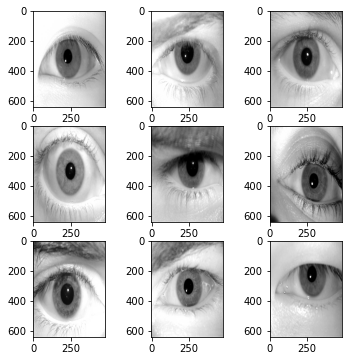

Found 3561 images belonging to 2 classes.
Found 1032 images belonging to 2 classes.


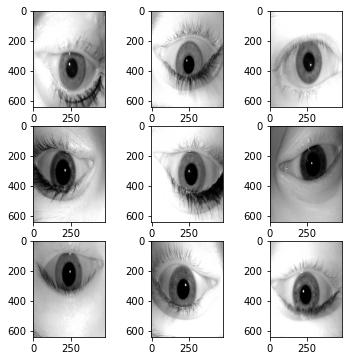

In [4]:
# example of horizontal shift image augmentation
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
import matplotlib.pyplot as plt

batch_size = 1

# entry point, run the test harness
file = '../data/processed/iris_data/LG2200/gender/train/Male/02463d1896.tiff'
width, height = imagesize.get(file)
print(width, height)


# entry point, run the test harness
dataset_home = '../data/processed/iris_data/LG2200/gender/'

train_path = dataset_home + 'train/'
test_path = dataset_home + 'test/'


train_datagen = ImageDataGenerator()


# prepare iterators
train_it = train_datagen.flow_from_directory(train_path,
    class_mode='binary', batch_size=batch_size, target_size=(640, 480))
test_it = train_datagen.flow_from_directory(test_path,
    class_mode='binary', batch_size=batch_size, target_size=(640, 480)) 



train_it.reset

fig = plt.figure(figsize=(6, 6))

# plot first few images
for i in range(9):
    # define subplot
    ax = fig.add_subplot(3,3, i+1)
    # generate batch of images
    x_batch, y_batch = train_it.next()
    # convert to unsigned integers for viewing
    image = x_batch[0].astype('uint8')
    # plot raw pixel data
    plt.imshow(image)
# show the figure
plt.show()



# prueba = load_all_images(train_path+'Male', height, width, 'tiff')
shift = 0.1
# train_datagen = ImageDataGenerator(preprocessing_function=normalise_features,horizontal_flip=True, vertical_flip=True)
train_datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
# train_datagen.fit(load_all_images(train_path+'Male', height, width, 'tiff'))
# train_datagen.fit(load_all_images(train_path+'Female', height, width, 'tiff'))


# prepare iterators
train_it = train_datagen.flow_from_directory(train_path,
    class_mode='binary', batch_size=batch_size, target_size=(640, 480))
test_it = train_datagen.flow_from_directory(test_path,
    class_mode='binary', batch_size=batch_size, target_size=(640, 480)) 



train_it.reset
fig = plt.figure(figsize=(6, 6))
    
# plot first few images
for i in range(9):
    # define subplot
    ax = fig.add_subplot(3,3, i+1)
    # generate batch of images
    x_batch, y_batch = train_it.next()
    # convert to unsigned integers for viewing
    image = x_batch[0].astype('uint8')
    # plot raw pixel data
    plt.imshow(image)
# show the figure
plt.show()



#### Training Neural network

In [3]:
# run the test harness for evaluating a model
#def run_test_harness():
batch_size = 128
epochs = 20
dropout = 0.8
learning_rate = 1e-6


In [4]:
# entry point, run the test harness
file = '../data/processed/iris_data/LG2200/gender/train/Male/02463d1896.tiff'
width, height = imagesize.get(file)
print(width, height)


# entry point, run the test harness
dataset_home = '../data/processed/iris_data/LG2200/gender/'

train_path = dataset_home + 'train/'
test_path = dataset_home + 'test/'

# prueba = load_all_images(train_path+'Male', height, width, 'tiff')

shift = 0.1
train_datagen = ImageDataGenerator(preprocessing_function=normalise_features,
								   rotation_range=90,
								   width_shift_range=shift, 
								   height_shift_range=shift,
								   zoom_range=0.3,
								   horizontal_flip=True, 
								   vertical_flip=True)
train_datagen.fit(load_all_images(train_path+'Male', height, width, 'tiff'))
train_datagen.fit(load_all_images(train_path+'Female', height, width, 'tiff'))


# prepare iterators
train_it = train_datagen.flow_from_directory(train_path,
    class_mode='binary', batch_size=batch_size, target_size=(224, 224))
# test_it = test_datagen.flow_from_directory(test_path,
#     class_mode='binary', batch_size=batch_size, target_size=(240, 320))    
test_it = train_datagen.flow_from_directory(test_path,
    class_mode='binary', batch_size=batch_size, target_size=(224, 224)) 

640 480


D:\vhcg77\anaconda3\envs\tf-gpu\lib\site-packages\keras_preprocessing\image\utils.py:173: UserWarning: Using ".tiff" files with multiple bands will cause distortion. Please verify your output.
  warnings.warn('Using ".tiff" files with multiple bands '


Found 3561 images belonging to 2 classes.
Found 1032 images belonging to 2 classes.


In [5]:
# Define Model
mobilenetModel=MobileNet(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.
# for layer in mobilenetModel.layers:
#     layer.trainable = False
x=mobilenetModel.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
output=Dense(1,activation='sigmoid')(x) #final layer with softmax activation

# # define new model
baseModel = Model(inputs=mobilenetModel.inputs, outputs=output)

# # Check the trainable status of the individual layers
# print("\r\r\r\r")
# for layer in baseModel.layers:
#     print("{}: {}".format(layer, layer.trainable))

# Fine-tune from this layer onwards
fine_tune_at = 87

# Freeze all the layers before the `fine_tune_at` layer
for layer in baseModel.layers:
    layer.trainable=False
for layer in baseModel.layers[:fine_tune_at]:
  layer.trainable =  False
for layer in baseModel.layers[fine_tune_at:]:
    layer.trainable=True

# # Check the trainable status of the individual layers
# print("\r\r\r\r")
# for layer in baseModel.layers:
#     print("{}: {}".format(layer, layer.trainable))
    
# compile model
# opt = SGD(lr=learning_rate, momentum=0.9)
# opt = RMSprop(learning_rate=0.0001, rho=0.99)
# opt = Adagrad(learning_rate=0.001)
# opt = Adadelta(learning_rate=1.0, rho=0.99)
# opt = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=True)
opt = Adamax(learning_rate=0.0034, beta_1=0.9, beta_2=0.999)
# opt = Nadam(learning_rate=0.002, beta_1=0.9, beta_2=0.999)
# baseModel.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])
baseModel.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# learning schedule callback
lrate = LearningRateScheduler(exp_decay)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                          patience=5, min_lr=0.01)

tensorboard = TensorBoard(log_dir="logs/{}".format(time()))

# callbacks_list = [ModelCheckpoint(filepath='model.h5', save_best_only=True)]
callbacks_list = [tensorboard]
# fit model
n_times = 5*len(train_it)
history1 = baseModel.fit_generator(train_it, steps_per_epoch=n_times, 
                                  validation_data=test_it, 
                                  validation_steps=len(test_it), 
                                  epochs=epochs, verbose=1,
                                  callbacks=callbacks_list)
# evaluate model
test_it.reset()

_, acc = baseModel.evaluate_generator(test_it, steps=len(test_it), verbose=0)
print(train_it.class_indices)
#print(baseModel.summary())
print('> %.3f' % (acc * 100.0))
# learning curves
summarize_diagnostics(history1)
#print_metrics(baseModel, test_datagen, test_path)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


D:\vhcg77\anaconda3\envs\tf-gpu\lib\site-packages\keras_applications\mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/200
25/25 [==============================] - 449s 18s/step - loss: 1.6351 - accuracy: 0.5489 - val_loss: 0.6613 - val_accuracy: 0.6599

Epoch 2/200
25/25 [==============================] - 464s 19s/step - loss: 0.5600 - accuracy: 0.7104 - val_loss: 0.5521 - val_accuracy: 0.7054
Epoch 3/200
25/25 [==============================] - 469s 19s/step - loss: 0.4864 - accuracy: 0.7601 - val_loss: 0.5786 - val_accuracy: 0.6860
Epoch 4/200
25/25 [==============================] - 473s 19s/step - loss: 0.4639 - accuracy: 0.7728 - val_loss: 0.5314 - val_accuracy: 0.7112
Epoch 5/200
25/25 [==============================] - 426s 17s/step - loss: 0.4481 - accuracy: 0.7856 - val_loss: 0.6300 - val_accuracy: 0.6715
Epoch 6/200
25/25 [==============================] - 388s 16s/step - loss: 0.4507 - accuracy: 0.7811 - val_loss: 0.6242 - val_accuracy: 0.6647
Epoch 7/200
25/25 [=========================

D:\vhcg77\anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\data_utils.py:616: UserWarning: The input 0 could not be retrieved. It could be because a worker has died.
  UserWarning)


25/25 [==============================] - 405s 16s/step - loss: 0.2579 - accuracy: 0.8889 - val_loss: 0.7279 - val_accuracy: 0.6793
Epoch 54/200
25/25 [==============================] - 387s 15s/step - loss: 0.2529 - accuracy: 0.8880 - val_loss: 0.7088 - val_accuracy: 0.6628
Epoch 55/200
25/25 [==============================] - 367s 15s/step - loss: 0.2486 - accuracy: 0.8940 - val_loss: 0.9187 - val_accuracy: 0.6182
Epoch 56/200
25/25 [==============================] - 349s 14s/step - loss: 0.2662 - accuracy: 0.8849 - val_loss: 0.8815 - val_accuracy: 0.6017
Epoch 57/200
25/25 [==============================] - 349s 14s/step - loss: 0.2413 - accuracy: 0.8985 - val_loss: 0.7877 - val_accuracy: 0.6483
Epoch 58/200
25/25 [==============================] - 345s 14s/step - loss: 0.2619 - accuracy: 0.8877 - val_loss: 0.7870 - val_accuracy: 0.6599
Epoch 59/200
25/25 [==============================] - 347s 14s/step - loss: 0.2453 - accuracy: 0.8934 - val_loss: 0.8015 - val_accuracy: 0.6541
Epoch

KeyboardInterrupt: 

In [9]:
# evaluate model
test_it.reset()

_, acc = baseModel.evaluate_generator(test_it, steps=len(test_it), verbose=0)
print(train_it.class_indices)
#print(baseModel.summary())
print('> %.3f' % (acc * 100.0))


{'Female': 0, 'Male': 1}
> 63.566


In [6]:
baseModel.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 32)    128 

In [7]:
# Check the trainable status of the individual layers
print("\r\r\r\r")
for layer in baseModel.layers:
    print("{}: {}".format(layer, layer.trainable))


<keras.engine.input_layer.InputLayer object at 0x000002D6410178C8>: False
<keras.layers.convolutional.ZeroPadding2D object at 0x000002D640EEC248>: False
<keras.layers.convolutional.Conv2D object at 0x000002D6411D8348>: False
<keras.layers.normalization.BatchNormalization object at 0x000002D6411A1E08>: False
<keras.layers.advanced_activations.ReLU object at 0x000002D63F7CF3C8>: False
<keras.layers.convolutional.DepthwiseConv2D object at 0x000002D64120B088>: False
<keras.layers.normalization.BatchNormalization object at 0x000002D641019208>: False
<keras.layers.advanced_activations.ReLU object at 0x000002D6411ADB88>: False
<keras.layers.convolutional.Conv2D object at 0x000002D641196188>: False
<keras.layers.normalization.BatchNormalization object at 0x000002D64119BE48>: False
<keras.layers.advanced_activations.ReLU object at 0x000002D641068208>: False
<keras.layers.convolutional.ZeroPadding2D object at 0x000002D641189148>: False
<keras.layers.convolutional.DepthwiseConv2D object at 0x000

In [10]:
baseModel.save('Base_Model_3.h5')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/20
140/140 [==============================] - 352s 3s/step - loss: 0.1276 - accuracy: 0.9480 - val_loss: 0.9806 - val_accuracy: 0.6609

Epoch 2/20
140/140 [==============================] - 346s 2s/step - loss: 0.1230 - accuracy: 0.9505 - val_loss: 1.3316 - val_accuracy: 0.6957
Epoch 3/20
140/140 [==============================] - 350s 3s/step - loss: 0.1229 - accuracy: 0.9504 - val_loss: 0.3795 - val_accuracy: 0.7016
Epoch 4/20
140/140 [==============================] - 349s 2s/step - loss: 0.1211 - accuracy: 0.9525 - val_loss: 0.2237 - val_accuracy: 0.6957
Epoch 5/20
140/140 [==============================] - 350s 3s/step - loss: 0.1190 - accuracy: 0.9538 - val_loss: 0.1944 - val_accuracy: 0.7229
Epoch 6/20
140/140 [==============================] - 404s 3s/step - loss: 0.1211 - accuracy: 0.9515 - val

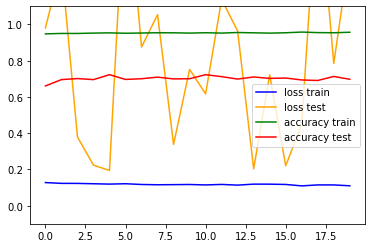

In [7]:

# Duplicate Model
# model= clone_model(baseModel)
model_with_last_20_layers = load_model('Base_Model_3.h5')

# # loop over the layers in the model and show which ones are trainable
# # or not
# print("\r\r\r\r")
# for layer in model_with_last_20_layers.layers:
#     print("{}: {}".format(layer, layer.trainable))


# Fine-tune from this layer onwards
fine_tune_at = 20

# Freeze all the layers before the `fine_tune_at` layer
for layer in model_with_last_20_layers.layers:
    layer.trainable=False
for layer in model_with_last_20_layers.layers[:fine_tune_at]:
  layer.trainable =  False
for layer in model_with_last_20_layers.layers[fine_tune_at:]:
    layer.trainable=True


# # loop over the layers in the model and show which ones are trainable
# # or not
# print("\r\r\r\r")
# for layer in model_with_last_20_layers.layers:
#     print("{}: {}".format(layer, layer.trainable))

# compile model
#opt = SGD(lr=1.0e-6, momentum=0.9)
opt = SGD(lr=learning_rate, momentum=0.9)
# opt = Adamax(learning_rate=0.0034, beta_1=0.9, beta_2=0.999)
model_with_last_20_layers.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# learning schedule callback
lrate = LearningRateScheduler(exp_decay)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                          patience=5, min_lr=0.001)

tensorboard = TensorBoard(log_dir="logs/{}".format(time()))

# callbacks_list = [ModelCheckpoint(filepath='model.h5', save_best_only=True)]
callbacks_list = [tensorboard]
# fit model
n_times = 5*len(train_it)
history_awith_last_20_layers = model_with_last_20_layers.fit_generator(train_it, steps_per_epoch=n_times, 
                                                                      validation_data=test_it, 
                                                                      validation_steps=len(test_it), 
                                                                      epochs=epochs, verbose=1, 
                                                                      callbacks=callbacks_list)
# evaluate model
test_it.reset()
_, acc = model_with_last_20_layers.evaluate_generator(test_it, steps=len(test_it), verbose=0)
print(train_it.class_indices)
#print(model.summary())
print('> %.3f' % (acc * 100.0))
# learning curves
summarize_diagnostics(history_awith_last_20_layers)
#print_metrics(model, test_datagen, test_path)
    
    
# entry point, run the test harness
# dataset_home = '../data/processed/iris_data/LG2200/gender/'
#run_test_harness()

In [7]:
model_with_last_20_layers.save('Base_Model_fine_tuned_3.h5')

In [9]:
test_path = '../data/raw/iris_data/LG4000/gender/'

# Duplicate Model
# model= clone_model(baseModel)
model = load_model('Base_Model_fine_tuned.h5')


# entry point, run the test harness
file = '../data/processed/iris_data/LG2200/gender/train/Male/02463d1896.tiff'
width, height = imagesize.get(file)
print(width, height)


# prueba = load_all_images(train_path+'Male', height, width, 'tiff')
train_datagen = ImageDataGenerator(preprocessing_function=normalise_features)
train_datagen.fit(load_all_images(test_path+'Male', height, width, 'tiff'))
train_datagen.fit(load_all_images(test_path+'Female', height, width, 'tiff'))

# prepare iterators
test_it = train_datagen.flow_from_directory(test_path,
    class_mode='binary', batch_size=batch_size, target_size=(240, 320)) 


# evaluate model
test_it.reset()
_, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
#print(model.summary())
print('> %.3f' % (acc * 100.0))



640 480
Found 4630 images belonging to 2 classes.
> 74.428


### Train with 224x224 images

In [2]:
# vgg16 model used for transfer learning on the dogs and cats dataset
import sys
from time import time
from matplotlib import pyplot
from keras.utils import to_categorical
from keras.applications.mobilenet import MobileNet
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras.optimizers import Adadelta
from keras.optimizers import Adagrad
from keras.optimizers import Adam
from keras.optimizers import Adamax
from keras.optimizers import Nadam
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model

# baseline model for the dogs vs cats dataset
import sys
from matplotlib import pyplot
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Activation
from keras.layers import Add
from keras.layers import Dropout
from keras.layers import GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import TensorBoard
from keras import backend as K

from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import numpy as np
from math import exp
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import classification_report

from pathlib import Path
from PIL import Image
import imagesize

Using TensorFlow backend.


In [3]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
    plt.plot(history.history['loss'],
                color='blue', label='loss train')
    plt.plot(history.history['val_loss'],
                color='orange', label='loss test')
    plt.plot(history.history['accuracy'],
                color='green', label='accuracy train')
    plt.plot(history.history['val_accuracy'],
                color='red', label='accuracy test')
    plt.ylim(bottom = -0.1, top = 1.1)
    plt.legend()
    plt.show()


def pretty_print_conf_matrix(y_true, y_pred, 
                             classes,
                             normalize=False,
                             title='Confusion matrix',
                             cmap=plt.cm.Blues):
    """
    Mostly stolen from: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

    Normalization changed, classification_report stats added below plot
    """

    cm = confusion_matrix(y_true, y_pred)

    # Configure Confusion Matrix Plot Aesthetics (no text yet) 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)

    # Calculate normalized values (so all cells sum to 1) if desired
    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(),2) #(axis=1)[:, np.newaxis]

    # Place Numbers as Text on Confusion Matrix Plot
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=12)


    # Add Precision, Recall, F-1 Score as Captions Below Plot
    rpt = classification_report(y_true, y_pred)
    rpt = rpt.replace('avg / total', '      avg')
    rpt = rpt.replace('support', 'N Obs')

    plt.annotate(rpt, 
                 xy = (0,0), 
                 xytext = (-50, -140), 
                 xycoords='axes fraction', textcoords='offset points',
                 fontsize=12, ha='right')    

    # Plot
    plt.tight_layout()


def print_metrics(model, datagen, test_path):
    
    test_it = datagen.flow_from_directory(test_path,
                                          class_mode='binary',
                                          batch_size=64,
                                          target_size=(240, 320))
    
    test_generator = datagen.flow_from_directory(test_path,
                                          class_mode='binary',
                                          batch_size=1,
                                          target_size=(240, 320))    
    # predict probabilities for test set
    filenames = test_generator.filenames
    nb_samples = len(filenames)
    true_values = []
    predictions = []
    for i in range(nb_samples):
        x_batch, y_batch = test_generator.next()
        name = model.predict(x_batch)
        name =  (name>0.5).astype(int)[0][0]
        true_name = y_batch[0].astype(np.int)
        label_map = (test_generator.class_indices)
        label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
        prediction = label_map[name]
        true_value = label_map[true_name]
        true_values.append(true_value)
        predictions.append(prediction) 
    plt.figure()
    pretty_print_conf_matrix(true_values, predictions, 
                             classes= ['Female', 'Male'])



def exp_decay(epoch):
    initial_lrate = 0.01
    k = 0.05
    lrate = initial_lrate * exp(-k*epoch)
    return lrate

def read_pil_image(img_path, height, width):
        with open(img_path, 'rb') as f:
            return np.array(Image.open(f).convert('RGB').resize((width, height)))

def load_all_images(dataset_path, height, width, img_ext='png'):
    return np.array([read_pil_image(str(p), height, width) for p in 
                                    Path(dataset_path).rglob("*."+img_ext)]) 

def normalise_features(array):
    min_value = -1
    max_value = 1
    return np.interp(array, (np.amin(array), np.amax(array)),
                     (min_value, max_value))


In [4]:
# run the test harness for evaluating a model
#def run_test_harness():
batch_size = 32
epochs = 200
dropout = 0.8
learning_rate = 1e-5


In [5]:
# entry point, run the test harness
file = '../data/processed/iris_data/LG2200/gender/train/Male/02463d1896.tiff'
width, height = imagesize.get(file)
print(width, height)


# entry point, run the test harness
dataset_home = '../data/processed/iris_data/LG2200/gender/'

train_path = dataset_home + 'train/'
test_path = dataset_home + 'test/'

# prueba = load_all_images(train_path+'Male', height, width, 'tiff')

train_datagen = ImageDataGenerator(preprocessing_function=normalise_features)
train_datagen.fit(load_all_images(train_path+'Male', height, width, 'tiff'))
train_datagen.fit(load_all_images(train_path+'Female', height, width, 'tiff'))
# train_datagen.fit(load_all_images(test_path+'Male', height, width, 'tiff'))
# train_datagen.fit(load_all_images(test_path+'Female', height, width, 'tiff'))

# test_datagen = ImageDataGenerator(preprocessing_function=normalise_features)
# test_datagen.fit(load_all_images(train_path+'Male', height, width, 'tiff'))
# test_datagen.fit(load_all_images(train_path+'Female', height, width, 'tiff'))
# test_datagen.fit(load_all_images(test_path+'Male', height, width, 'tiff'))
# test_datagen.fit(load_all_images(test_path+'Female', height, width, 'tiff'))


# prepare iterators
train_it = train_datagen.flow_from_directory(train_path,
    class_mode='binary', batch_size=batch_size, target_size=(224, 224))
# test_it = test_datagen.flow_from_directory(test_path,
#     class_mode='binary', batch_size=batch_size, target_size=(240, 320))    
test_it = train_datagen.flow_from_directory(test_path,
    class_mode='binary', batch_size=batch_size, target_size=(224, 224)) 

640 480


D:\vhcg77\anaconda3\envs\tf-gpu\lib\site-packages\keras_preprocessing\image\utils.py:173: UserWarning: Using ".tiff" files with multiple bands will cause distortion. Please verify your output.
  warnings.warn('Using ".tiff" files with multiple bands '


Found 3561 images belonging to 2 classes.
Found 1032 images belonging to 2 classes.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


D:\vhcg77\Anaconda3\envs\tensorflow\lib\site-packages\keras_applications\mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


17227776/17225924 [==============================] - 2s 0us/step
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/200
112/112 [==============================] - 44s 392ms/step - loss: 0.6998 - accuracy: 0.5074 - val_loss: 0.6359 - val_accuracy: 0.5068

Epoch 2/200
112/112 [==============================] - 30s 268ms/step - loss: 0.6914 - accuracy: 0.5352 - val_loss: 0.8573 - val_accuracy: 0.5068
Epoch 3/200
112/112 [==============================] - 31s 273ms/step - loss: 0.6855 - accuracy: 0.5484 - val_loss: 0.6152 - val_accuracy: 0.4932
Epoch 4/200
112/112 [==============================] - 31s 274ms/step - loss: 0.6818 - accuracy: 0.5538 - val_loss: 0.8506 - val_accuracy: 0.5048
Epoch 5/200
112/112 [==============================] - 33s 291ms/step - loss: 0.6774 - accuracy: 0.5715 - val_loss: 0.7588 - val_accuracy: 0.5087
Epoch 6/200
112/112 [==============================] - 31s 280ms/step - loss: 0.6742 - accuracy: 0.5844 - v

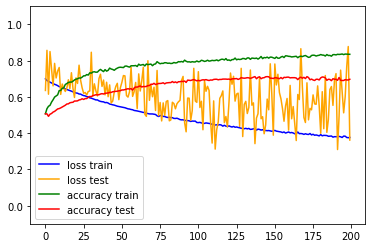

In [5]:
# Define Model
mobilenetModel=MobileNet(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.
# for layer in mobilenetModel.layers:
#     layer.trainable = False
x=mobilenetModel.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
output=Dense(1,activation='sigmoid')(x) #final layer with softmax activation

# # define new model
baseModel = Model(inputs=mobilenetModel.inputs, outputs=output)

# # Check the trainable status of the individual layers
# print("\r\r\r\r")
# for layer in baseModel.layers:
#     print("{}: {}".format(layer, layer.trainable))

# Fine-tune from this layer onwards
fine_tune_at = 87

# Freeze all the layers before the `fine_tune_at` layer
for layer in baseModel.layers:
    layer.trainable=False
for layer in baseModel.layers[:fine_tune_at]:
  layer.trainable =  False
for layer in baseModel.layers[fine_tune_at:]:
    layer.trainable=True

# # Check the trainable status of the individual layers
# print("\r\r\r\r")
# for layer in baseModel.layers:
#     print("{}: {}".format(layer, layer.trainable))
    
# compile model
# opt = SGD(lr=learning_rate, momentum=0.9)
# opt = RMSprop(learning_rate=0.0001, rho=0.99)
# opt = Adagrad(learning_rate=0.001)
# opt = Adadelta(learning_rate=1.0, rho=0.99)
# opt = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=True)
opt = Adamax(learning_rate=0.0034, beta_1=0.9, beta_2=0.999)
# opt = Nadam(learning_rate=0.002, beta_1=0.9, beta_2=0.999)
# baseModel.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])
baseModel.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# learning schedule callback
lrate = LearningRateScheduler(exp_decay)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                          patience=5, min_lr=0.01)

tensorboard = TensorBoard(log_dir="logs/{}".format(time()))

# callbacks_list = [ModelCheckpoint(filepath='model.h5', save_best_only=True)]
callbacks_list = [tensorboard]
# fit model
history1 = baseModel.fit_generator(train_it, steps_per_epoch=len(train_it), 
                                  validation_data=test_it, 
                                  validation_steps=len(test_it), 
                                  epochs=epochs, verbose=1,
                                  callbacks=callbacks_list)
# evaluate model
test_it.reset()
_, acc = baseModel.evaluate_generator(test_it, steps=len(test_it), verbose=0)
print(train_it.class_indices)
#print(baseModel.summary())
print('> %.3f' % (acc * 100.0))
# learning curves
summarize_diagnostics(history1)
#print_metrics(baseModel, test_datagen, test_path)


In [6]:
baseModel.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 32)    128 

In [16]:
# Check the trainable status of the individual layers
print("\r\r\r\r")
for layer in baseModel.layers:
    print("{}: {}".format(layer, layer.trainable))


<keras.engine.input_layer.InputLayer object at 0x000002477AA60348>: False
<keras.layers.convolutional.ZeroPadding2D object at 0x0000024775723548>: False
<keras.layers.convolutional.Conv2D object at 0x00000247757C96C8>: False
<keras.layers.normalization.BatchNormalization object at 0x0000024775581248>: False
<keras.layers.advanced_activations.ReLU object at 0x00000247755814C8>: False
<keras.layers.convolutional.DepthwiseConv2D object at 0x00000247516F0948>: False
<keras.layers.normalization.BatchNormalization object at 0x000002477ADD9AC8>: False
<keras.layers.advanced_activations.ReLU object at 0x00000247833AA0C8>: False
<keras.layers.convolutional.Conv2D object at 0x00000247833AA7C8>: False
<keras.layers.normalization.BatchNormalization object at 0x000002477E485288>: False
<keras.layers.advanced_activations.ReLU object at 0x000002477ADEB0C8>: False
<keras.layers.convolutional.ZeroPadding2D object at 0x000002477E488648>: False
<keras.layers.convolutional.DepthwiseConv2D object at 0x000

In [7]:
baseModel.save('Base_Model_2.h5')

Epoch 1/200
112/112 [==============================] - 42s 377ms/step - loss: 0.3736 - accuracy: 0.8343 - val_loss: 0.7036 - val_accuracy: 0.7287
Epoch 2/200
112/112 [==============================] - 38s 338ms/step - loss: 0.3625 - accuracy: 0.8425 - val_loss: 0.2671 - val_accuracy: 0.7432
Epoch 3/200
112/112 [==============================] - 37s 334ms/step - loss: 0.3651 - accuracy: 0.8441 - val_loss: 0.3628 - val_accuracy: 0.7510
Epoch 4/200
112/112 [==============================] - 38s 340ms/step - loss: 0.3636 - accuracy: 0.8366 - val_loss: 0.5305 - val_accuracy: 0.7539
Epoch 5/200
112/112 [==============================] - 38s 343ms/step - loss: 0.3601 - accuracy: 0.8461 - val_loss: 0.5083 - val_accuracy: 0.7548
Epoch 6/200
112/112 [==============================] - 38s 336ms/step - loss: 0.3460 - accuracy: 0.8526 - val_loss: 0.5661 - val_accuracy: 0.7539
Epoch 7/200
112/112 [==============================] - 38s 339ms/step - loss: 0.3505 - accuracy: 0.8517 - val_loss: 0.2554 -

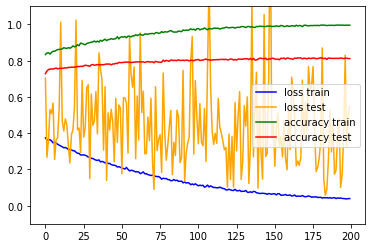

In [8]:

# Duplicate Model
# model= clone_model(baseModel)
model_with_last_20_layers = load_model('Base_Model_2.h5')

# # loop over the layers in the model and show which ones are trainable
# # or not
# print("\r\r\r\r")
# for layer in model_with_last_20_layers.layers:
#     print("{}: {}".format(layer, layer.trainable))


# Fine-tune from this layer onwards
fine_tune_at = 20

# Freeze all the layers before the `fine_tune_at` layer
for layer in model_with_last_20_layers.layers:
    layer.trainable=False
for layer in model_with_last_20_layers.layers[:fine_tune_at]:
  layer.trainable =  False
for layer in model_with_last_20_layers.layers[fine_tune_at:]:
    layer.trainable=True


# # loop over the layers in the model and show which ones are trainable
# # or not
# print("\r\r\r\r")
# for layer in model_with_last_20_layers.layers:
#     print("{}: {}".format(layer, layer.trainable))

# compile model
#opt = SGD(lr=1.0e-6, momentum=0.9)
opt = SGD(lr=learning_rate, momentum=0.9)
model_with_last_20_layers.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# learning schedule callback
lrate = LearningRateScheduler(exp_decay)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                          patience=5, min_lr=0.001)

tensorboard = TensorBoard(log_dir="logs/{}".format(time()))

# callbacks_list = [ModelCheckpoint(filepath='model.h5', save_best_only=True)]
callbacks_list = [tensorboard]
# fit model
history_awith_last_20_layers = model_with_last_20_layers.fit_generator(train_it, steps_per_epoch=len(train_it), 
                                                                      validation_data=test_it, 
                                                                      validation_steps=len(test_it), 
                                                                      epochs=epochs, verbose=1, 
                                                                      callbacks=callbacks_list)
# evaluate model
test_it.reset()
_, acc = model_with_last_20_layers.evaluate_generator(test_it, steps=len(test_it), verbose=0)
print(train_it.class_indices)
#print(model.summary())
print('> %.3f' % (acc * 100.0))
# learning curves
summarize_diagnostics(history_awith_last_20_layers)
#print_metrics(model, test_datagen, test_path)
    
    
# entry point, run the test harness
# dataset_home = '../data/processed/iris_data/LG2200/gender/'
#run_test_harness()

In [9]:
model_with_last_20_layers.save('Base_Model_fine_tuned_2.h5')

In [10]:
test_path = '../data/raw/iris_data/LG4000/gender/'

# Duplicate Model
# model= clone_model(baseModel)
model = load_model('Base_Model_fine_tuned_2.h5')


# entry point, run the test harness
file = '../data/processed/iris_data/LG2200/gender/train/Male/02463d1896.tiff'
width, height = imagesize.get(file)
print(width, height)


# prueba = load_all_images(train_path+'Male', height, width, 'tiff')
train_datagen = ImageDataGenerator(preprocessing_function=normalise_features)
train_datagen.fit(load_all_images(test_path+'Male', height, width, 'tiff'))
train_datagen.fit(load_all_images(test_path+'Female', height, width, 'tiff'))

# prepare iterators
test_it = train_datagen.flow_from_directory(test_path,
    class_mode='binary', batch_size=batch_size, target_size=(240, 320)) 


# evaluate model
test_it.reset()
_, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
#print(model.summary())
print('> %.3f' % (acc * 100.0))



640 480
Found 4630 images belonging to 2 classes.
> 74.039


### Removing neck bottle

In [1]:
import tensorflow as tf

In [1]:
import sys
from time import time
from matplotlib import pyplot
from keras.utils import to_categorical
from keras.applications.mobilenet import MobileNet
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras.optimizers import Adadelta
from keras.optimizers import Adagrad
from keras.optimizers import Adam
from keras.optimizers import Adamax
from keras.optimizers import Nadam
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model

# baseline model for the dogs vs cats dataset
import sys
from matplotlib import pyplot
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Activation
from keras.layers import Add
from keras.layers import Dropout
from keras.layers import GlobalAveragePooling2D
from keras.layers import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import TensorBoard
from keras import backend as K

from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import numpy as np
from math import exp
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import classification_report

from pathlib import Path
from PIL import Image
import imagesize

Using TensorFlow backend.


In [2]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
    plt.plot(history.history['loss'],
                color='blue', label='loss train')
    plt.plot(history.history['val_loss'],
                color='orange', label='loss test')
    plt.plot(history.history['accuracy'],
                color='green', label='accuracy train')
    plt.plot(history.history['val_accuracy'],
                color='red', label='accuracy test')
    plt.ylim(bottom = -0.1, top = 1.1)
    plt.legend()
    plt.show()


def pretty_print_conf_matrix(y_true, y_pred, 
                             classes,
                             normalize=False,
                             title='Confusion matrix',
                             cmap=plt.cm.Blues):
    """
    Mostly stolen from: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

    Normalization changed, classification_report stats added below plot
    """

    cm = confusion_matrix(y_true, y_pred)

    # Configure Confusion Matrix Plot Aesthetics (no text yet) 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)

    # Calculate normalized values (so all cells sum to 1) if desired
    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(),2) #(axis=1)[:, np.newaxis]

    # Place Numbers as Text on Confusion Matrix Plot
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=12)


    # Add Precision, Recall, F-1 Score as Captions Below Plot
    rpt = classification_report(y_true, y_pred)
    rpt = rpt.replace('avg / total', '      avg')
    rpt = rpt.replace('support', 'N Obs')

    plt.annotate(rpt, 
                 xy = (0,0), 
                 xytext = (-50, -140), 
                 xycoords='axes fraction', textcoords='offset points',
                 fontsize=12, ha='right')    

    # Plot
    plt.tight_layout()


def print_metrics(model, datagen, test_path):
    
    test_it = datagen.flow_from_directory(test_path,
                                          class_mode='binary',
                                          batch_size=64,
                                          target_size=(240, 320))
    
    test_generator = datagen.flow_from_directory(test_path,
                                          class_mode='binary',
                                          batch_size=1,
                                          target_size=(240, 320))    
    # predict probabilities for test set
    filenames = test_generator.filenames
    nb_samples = len(filenames)
    true_values = []
    predictions = []
    for i in range(nb_samples):
        x_batch, y_batch = test_generator.next()
        name = model.predict(x_batch)
        name =  (name>0.5).astype(int)[0][0]
        true_name = y_batch[0].astype(np.int)
        label_map = (test_generator.class_indices)
        label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
        prediction = label_map[name]
        true_value = label_map[true_name]
        true_values.append(true_value)
        predictions.append(prediction) 
    plt.figure()
    pretty_print_conf_matrix(true_values, predictions, 
                             classes= ['Female', 'Male'])



def exp_decay(epoch):
    initial_lrate = 0.01
    k = 0.05
    lrate = initial_lrate * exp(-k*epoch)
    return lrate

def read_pil_image(img_path, height, width):
        with open(img_path, 'rb') as f:
            return np.array(Image.open(f).convert('RGB').resize((width, height)))

def load_all_images(dataset_path, height, width, img_ext='png'):
    return np.array([read_pil_image(str(p), height, width) for p in 
                                    Path(dataset_path).rglob("*."+img_ext)]) 

def normalise_features(array):
    min_value = -1
    max_value = 1
    return np.interp(array, (np.amin(array), np.amax(array)),
                     (min_value, max_value))


In [3]:
# run the test harness for evaluating a model
#def run_test_harness():
batch_size = 64
epochs = 200
dropout = 0.8
learning_rate = 1e-5


In [4]:
# entry point, run the test harness
file = '../data/processed/iris_data/LG2200/gender/train/Male/02463d1896.tiff'
width, height = imagesize.get(file)
print(width, height)


# entry point, run the test harness
dataset_home = '../data/processed/iris_data/LG2200/gender/'

train_path = dataset_home + 'train/'
test_path = dataset_home + 'test/'

# prueba = load_all_images(train_path+'Male', height, width, 'tiff')

train_datagen = ImageDataGenerator(preprocessing_function=normalise_features)
train_datagen.fit(load_all_images(train_path+'Male', height, width, 'tiff'))
train_datagen.fit(load_all_images(train_path+'Female', height, width, 'tiff'))
# train_datagen.fit(load_all_images(test_path+'Male', height, width, 'tiff'))
# train_datagen.fit(load_all_images(test_path+'Female', height, width, 'tiff'))

# test_datagen = ImageDataGenerator(preprocessing_function=normalise_features)
# test_datagen.fit(load_all_images(train_path+'Male', height, width, 'tiff'))
# test_datagen.fit(load_all_images(train_path+'Female', height, width, 'tiff'))
# test_datagen.fit(load_all_images(test_path+'Male', height, width, 'tiff'))
# test_datagen.fit(load_all_images(test_path+'Female', height, width, 'tiff'))


# prepare iterators
train_it = train_datagen.flow_from_directory(train_path,
    class_mode='binary', batch_size=batch_size, target_size=(224, 224))
# test_it = test_datagen.flow_from_directory(test_path,
#     class_mode='binary', batch_size=batch_size, target_size=(240, 320))    
test_it = train_datagen.flow_from_directory(test_path,
    class_mode='binary', batch_size=batch_size, target_size=(224, 224)) 

640 480


D:\vhcg77\anaconda3\envs\tf-gpu\lib\site-packages\keras_preprocessing\image\utils.py:173: UserWarning: Using ".tiff" files with multiple bands will cause distortion. Please verify your output.
  warnings.warn('Using ".tiff" files with multiple bands '


Found 3561 images belonging to 2 classes.
Found 1032 images belonging to 2 classes.


In [5]:
# Define Model
mobilenetModel=MobileNet(weights='imagenet',
                         include_top=False,
                         pooling='max') #imports the mobilenet model and discards the last 1000 neuron layer.
# for layer in mobilenetModel.layers:
#     layer.trainable = False
x=mobilenetModel.output
#x=MaxPooling2D()
#x=GlobalAveragePooling2D()(x)
#x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
#x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
#x=Dense(256,activation='relu')(x) #dense layer 3
x=Dense(64,activation='relu')(x) #dense layer 3
output=Dense(1,activation='sigmoid')(x) #final layer with softmax activation

# # define new model
baseModel = Model(inputs=mobilenetModel.inputs, outputs=output)

# # Check the trainable status of the individual layers
# print("\r\r\r\r")
# for layer in baseModel.layers:
#     print("{}: {}".format(layer, layer.trainable))

# Fine-tune from this layer onwards
fine_tune_at = 87

# Freeze all the layers before the `fine_tune_at` layer
for layer in baseModel.layers:
    layer.trainable=False
for layer in baseModel.layers[:fine_tune_at]:
  layer.trainable =  False
for layer in baseModel.layers[fine_tune_at:]:
    layer.trainable=True

# # Check the trainable status of the individual layers
# print("\r\r\r\r")
# for layer in baseModel.layers:
#     print("{}: {}".format(layer, layer.trainable))
    
# compile model
# opt = SGD(lr=learning_rate, momentum=0.9)
# opt = RMSprop(learning_rate=0.0001, rho=0.99)
# opt = Adagrad(learning_rate=learning_rate)
# opt = Adadelta(learning_rate=1.0, rho=0.99)
# opt = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=True)
opt = Adamax(learning_rate=0.0034, beta_1=0.9, beta_2=0.999)
# opt = Nadam(learning_rate=0.002, beta_1=0.9, beta_2=0.999)
# baseModel.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])
baseModel.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# learning schedule callback
lrate = LearningRateScheduler(exp_decay)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                          patience=5, min_lr=0.01)

tensorboard = TensorBoard(log_dir="logs/{}".format(time()))

# callbacks_list = [ModelCheckpoint(filepath='model.h5', save_best_only=True)]
callbacks_list = [tensorboard]
# fit model
history1 = baseModel.fit_generator(train_it, steps_per_epoch=len(train_it), 
                                  validation_data=test_it, 
                                  validation_steps=len(test_it), 
                                  epochs=epochs, verbose=1,
                                  callbacks=callbacks_list)
# evaluate model
test_it.reset()
_, acc = baseModel.evaluate_generator(test_it, steps=len(test_it), verbose=0)
print(train_it.class_indices)
#print(baseModel.summary())
print('> %.3f' % (acc * 100.0))
# learning curves
summarize_diagnostics(history1)
#print_metrics(baseModel, test_datagen, test_path)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


D:\vhcg77\anaconda3\envs\tf-gpu\lib\site-packages\keras_applications\mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


17227776/17225924 [==============================] - 2s 0us/step
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/200
56/56 [==============================] - 40s 714ms/step - loss: 4.0855 - accuracy: 0.5313 - val_loss: 1.0566 - val_accuracy: 0.4952

Epoch 2/200
56/56 [==============================] - 30s 528ms/step - loss: 0.6566 - accuracy: 0.6428 - val_loss: 0.4597 - val_accuracy: 0.6153
Epoch 3/200
56/56 [==============================] - 32s 565ms/step - loss: 0.5839 - accuracy: 0.6905 - val_loss: 0.7027 - val_accuracy: 0.7151
Epoch 4/200
56/56 [==============================] - 29s 523ms/step - loss: 0.5032 - accuracy: 0.7509 - val_loss: 0.5312 - val_accuracy: 0.7171
Epoch 5/200
56/56 [==============================] - 31s 554ms/step - loss: 0.4887 - accuracy: 0.7582 - val_loss: 0.4694 - val_accuracy: 0.7287
Epoch 6/200
56/56 [==============================] - 31s 553ms/step - loss: 0.4677 - accuracy: 0.7765 - val_loss: 0.4

KeyboardInterrupt: 

In [7]:
baseModel.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 32)    128 

In [6]:
# Check the trainable status of the individual layers
print("\r\r\r\r")
for layer in baseModel.layers:
    print("{}: {}".format(layer, layer.trainable))


<keras.engine.input_layer.InputLayer object at 0x000001D5910FBB88>: False
<keras.layers.convolutional.ZeroPadding2D object at 0x000001D5910FAC08>: False
<keras.layers.convolutional.Conv2D object at 0x000001D5910FA608>: False
<keras.layers.normalization.BatchNormalization object at 0x000001D590FAD988>: False
<keras.layers.advanced_activations.ReLU object at 0x000001D590FB7E08>: False
<keras.layers.convolutional.DepthwiseConv2D object at 0x000001D591266748>: False
<keras.layers.normalization.BatchNormalization object at 0x000001D591105448>: False
<keras.layers.advanced_activations.ReLU object at 0x000001D590FA4288>: False
<keras.layers.convolutional.Conv2D object at 0x000001D5912A4088>: False
<keras.layers.normalization.BatchNormalization object at 0x000001D591146188>: False
<keras.layers.advanced_activations.ReLU object at 0x000001D590FA2788>: False
<keras.layers.convolutional.ZeroPadding2D object at 0x000001D590F92F48>: False
<keras.layers.convolutional.DepthwiseConv2D object at 0x000

In [7]:
baseModel.save('Base_Model_2.h5')

Epoch 1/200
112/112 [==============================] - 42s 377ms/step - loss: 0.3736 - accuracy: 0.8343 - val_loss: 0.7036 - val_accuracy: 0.7287
Epoch 2/200
112/112 [==============================] - 38s 338ms/step - loss: 0.3625 - accuracy: 0.8425 - val_loss: 0.2671 - val_accuracy: 0.7432
Epoch 3/200
112/112 [==============================] - 37s 334ms/step - loss: 0.3651 - accuracy: 0.8441 - val_loss: 0.3628 - val_accuracy: 0.7510
Epoch 4/200
112/112 [==============================] - 38s 340ms/step - loss: 0.3636 - accuracy: 0.8366 - val_loss: 0.5305 - val_accuracy: 0.7539
Epoch 5/200
112/112 [==============================] - 38s 343ms/step - loss: 0.3601 - accuracy: 0.8461 - val_loss: 0.5083 - val_accuracy: 0.7548
Epoch 6/200
112/112 [==============================] - 38s 336ms/step - loss: 0.3460 - accuracy: 0.8526 - val_loss: 0.5661 - val_accuracy: 0.7539
Epoch 7/200
112/112 [==============================] - 38s 339ms/step - loss: 0.3505 - accuracy: 0.8517 - val_loss: 0.2554 -

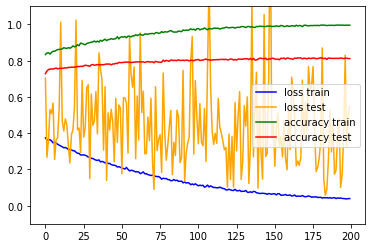

In [8]:

# Duplicate Model
# model= clone_model(baseModel)
model_with_last_20_layers = load_model('Base_Model_2.h5')

# # loop over the layers in the model and show which ones are trainable
# # or not
# print("\r\r\r\r")
# for layer in model_with_last_20_layers.layers:
#     print("{}: {}".format(layer, layer.trainable))


# Fine-tune from this layer onwards
fine_tune_at = 20

# Freeze all the layers before the `fine_tune_at` layer
for layer in model_with_last_20_layers.layers:
    layer.trainable=False
for layer in model_with_last_20_layers.layers[:fine_tune_at]:
  layer.trainable =  False
for layer in model_with_last_20_layers.layers[fine_tune_at:]:
    layer.trainable=True


# # loop over the layers in the model and show which ones are trainable
# # or not
# print("\r\r\r\r")
# for layer in model_with_last_20_layers.layers:
#     print("{}: {}".format(layer, layer.trainable))

# compile model
#opt = SGD(lr=1.0e-6, momentum=0.9)
opt = SGD(lr=learning_rate, momentum=0.9)
model_with_last_20_layers.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# learning schedule callback
lrate = LearningRateScheduler(exp_decay)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                          patience=5, min_lr=0.001)

tensorboard = TensorBoard(log_dir="logs/{}".format(time()))

# callbacks_list = [ModelCheckpoint(filepath='model.h5', save_best_only=True)]
callbacks_list = [tensorboard]
# fit model
history_awith_last_20_layers = model_with_last_20_layers.fit_generator(train_it, steps_per_epoch=len(train_it), 
                                                                      validation_data=test_it, 
                                                                      validation_steps=len(test_it), 
                                                                      epochs=epochs, verbose=1, 
                                                                      callbacks=callbacks_list)
# evaluate model
test_it.reset()
_, acc = model_with_last_20_layers.evaluate_generator(test_it, steps=len(test_it), verbose=0)
print(train_it.class_indices)
#print(model.summary())
print('> %.3f' % (acc * 100.0))
# learning curves
summarize_diagnostics(history_awith_last_20_layers)
#print_metrics(model, test_datagen, test_path)
    
    
# entry point, run the test harness
# dataset_home = '../data/processed/iris_data/LG2200/gender/'
#run_test_harness()

In [9]:
model_with_last_20_layers.save('Base_Model_fine_tuned_2.h5')

In [10]:
test_path = '../data/raw/iris_data/LG4000/gender/'

# Duplicate Model
# model= clone_model(baseModel)
model = load_model('Base_Model_fine_tuned_2.h5')


# entry point, run the test harness
file = '../data/processed/iris_data/LG2200/gender/train/Male/02463d1896.tiff'
width, height = imagesize.get(file)
print(width, height)


# prueba = load_all_images(train_path+'Male', height, width, 'tiff')
train_datagen = ImageDataGenerator(preprocessing_function=normalise_features)
train_datagen.fit(load_all_images(test_path+'Male', height, width, 'tiff'))
train_datagen.fit(load_all_images(test_path+'Female', height, width, 'tiff'))

# prepare iterators
test_it = train_datagen.flow_from_directory(test_path,
    class_mode='binary', batch_size=batch_size, target_size=(240, 320)) 


# evaluate model
test_it.reset()
_, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
#print(model.summary())
print('> %.3f' % (acc * 100.0))



640 480
Found 4630 images belonging to 2 classes.
> 74.039
